In [1]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob 
import random
import os

## Install Ultralytics Package

In [2]:
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 11.8 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


## Download the Dataset

In [3]:
os.makedirs('datasets', exist_ok=True)

In [4]:
%cd datasets

/content/datasets


In [5]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)
        
download_file(
    'https://www.dropbox.com/s/qvglw8pqo16769f/pothole_dataset_v8.zip?dl=1',
    'pothole_dataset_v8.zip'
)

In [6]:
# Unzip the data file
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('pothole_dataset_v8.zip')

Extracted all


In [7]:
%cd ..

/content


## Visualize Images from the Dataset

In [8]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [9]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))
                
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [10]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))
    
    all_images.sort()

    num_images = len(all_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

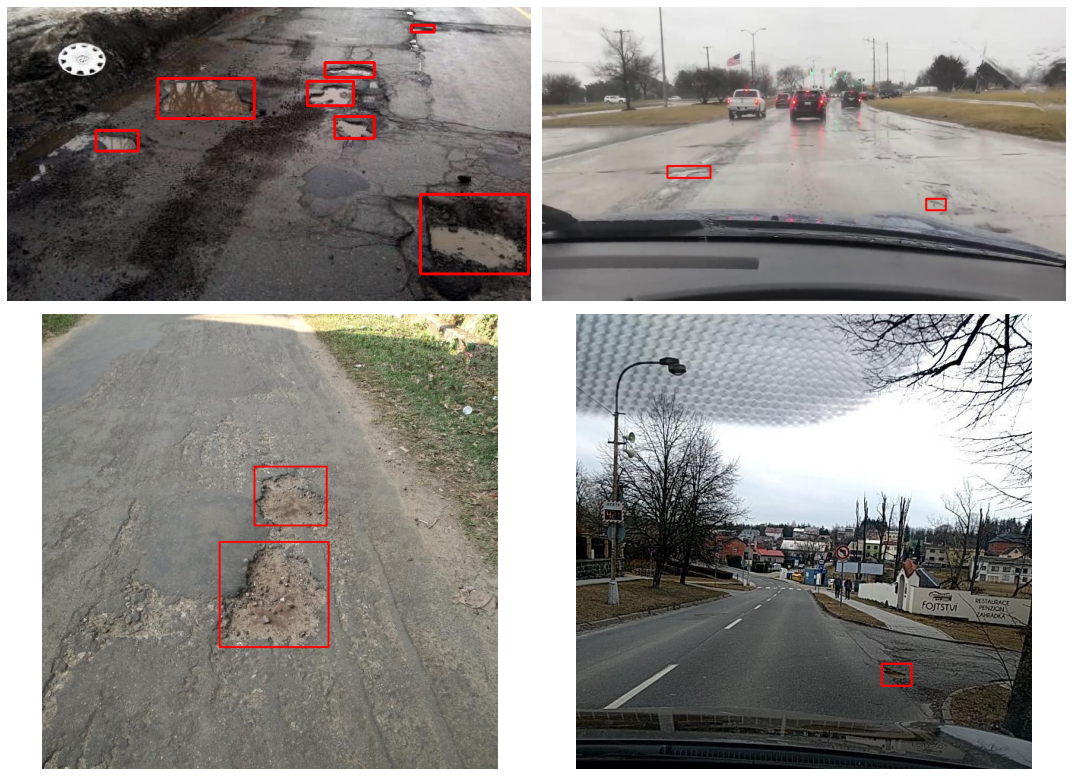

In [11]:
# Visualize a few training images.
plot(
    image_paths='datasets/pothole_dataset_v8/train/images/', 
    label_paths='datasets/pothole_dataset_v8/train/labels/',
    num_samples=4,
)

## Dataset YAML File

In [4]:
%%writefile pothole_v8.yaml
path: 'pothole_dataset_v8/'
train: 'train/images'
val: 'valid/images'

# class names
names: 
  0: 'pothole'

Writing pothole_v8.yaml


## YOLOv8 Nano Training

In [ ]:
# Sample training for 5 epoch.
EPOCHS = 5
!yolo task=detect mode=train model=yolov8n.pt imgsz=1280 data=pothole_v8.yaml epochs={EPOCHS} batch=8 name=yolov8n_v8_50e

100% 6.23M/6.23M [00:00<00:00, 84.8MB/s]

Ultralytics YOLOv8.0.21 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=pothole_v8.yaml, epochs=5, patience=50, batch=8, imgsz=1280, save=True, cache=False, device=, workers=8, project=None, name=yolov8n_v8_50e, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=

## Evaluation on Validation Images

In [8]:
!yolo task=detect mode=val model=runs/detect/yolov8n_v8_50e/weights/best.pt name=yolov8n_eval data=pothole_v8.yaml

Ultralytics YOLOv8.0.21 🚀 Python-3.9.15 torch-1.12.0+cu116 CUDA:0 (NVIDIA GeForce GTX 1060, 6078MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blo
val: WARNING ⚠️ /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011603.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011614.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011616.jpg: 2 duplicate labels removed
val: WARNING ⚠️ /media/sovit/hdd1tbinternal/my_data/Data_Scie

## Inference on Validation Images

In [3]:
!yolo task=detect \
mode=predict \
model=runs/detect/yolov8n_v8_50e/weights/best.pt \
source=datasets/pothole_dataset_v8/valid/images \
imgsz=1280 \
name=yolov8n_v8_50e_infer1280 \
hide_labels=True

Ultralytics YOLOv8.0.19 🚀 Python-3.9.15 torch-1.12.0+cu116 CUDA:0 (NVIDIA GeForce GTX 1060, 6078MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
image 1/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011195.jpg: 736x1280 13.8ms
image 2/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011196.jpg: 736x1280 1 pothole, 13.4ms
image 3/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011242.jpg: 736x1280 1 pothole, 13.2ms
image 4/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_

image 38/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011560.jpg: 736x1280 13.3ms
image 39/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011561.jpg: 736x1280 1 pothole, 13.3ms
image 40/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011562.jpg: 736x1280 2 potholes, 13.3ms
image 41/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011563.jpg: 736x1280 1 pothole, 13.4ms
image 42/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Compl

image 76/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011635.jpg: 736x1280 13.0ms
image 77/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011636.jpg: 736x1280 2 potholes, 13.2ms
image 78/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011637.jpg: 736x1280 1 pothole, 13.2ms
image 79/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011641.jpg: 736x1280 13.3ms
image 80/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutoria

image 114/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011774.jpg: 736x1280 2 potholes, 13.3ms
image 115/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011775.jpg: 736x1280 13.6ms
image 116/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011800.jpg: 736x1280 13.4ms
image 117/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011801.jpg: 736x1280 13.3ms
image 118/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/note

image 152/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011941.jpg: 736x1280 2 potholes, 12.9ms
image 153/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011942.jpg: 736x1280 1 pothole, 13.3ms
image 154/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011943.jpg: 736x1280 1 pothole, 13.0ms
image 155/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011947.jpg: 736x1280 2 potholes, 13.2ms
image 156/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Cus

image 189/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/img-101_jpg.rf.f2b523ae66c89b3576935bce8d6cff7f.jpg: 736x1280 13.1ms
image 190/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/img-103_jpg.rf.03b85ba0c77ecb807164864114366680.jpg: 736x1280 13.6ms
image 191/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/img-104_jpg.rf.b96781880df5be4533deb9aa122a5fa2.jpg: 736x1280 13.4ms
image 192/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/img-107_jpg.rf.047c32191fcb8b9394b556bc28d86b17.jpg: 736x1280

image 221/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/img-155_jpg.rf.1f2504bf50751764a9869bda1b9ff446.jpg: 736x1280 13.3ms
image 222/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/img-156_jpg.rf.7de75186c4dfad8e1880d129b8a9126f.jpg: 736x1280 13.3ms
image 223/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/img-158_jpg.rf.69910b385c47356ae1ae2c964ea3356e.jpg: 736x1280 13.3ms
image 224/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/img-159_jpg.rf.cebbb007cb512ee03704c25aef1a55b8.jpg: 736x1280

image 254/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/img-71_jpg.rf.a66c7ead4152e3634f1d01604a09729f.jpg: 736x1280 13.2ms
image 255/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/img-73_jpg.rf.4d0ebe8bd78382854887c85af26c88b0.jpg: 736x1280 13.3ms
image 256/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/img-74_jpg.rf.b6a7c408ac473908998a74a364e61587.jpg: 736x1280 13.1ms
image 257/271 /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/img-79_jpg.rf.00fb662d8b19ea40165f6597578c18db.jpg: 736x1280 13.

## Visualize Validation Results

In [4]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

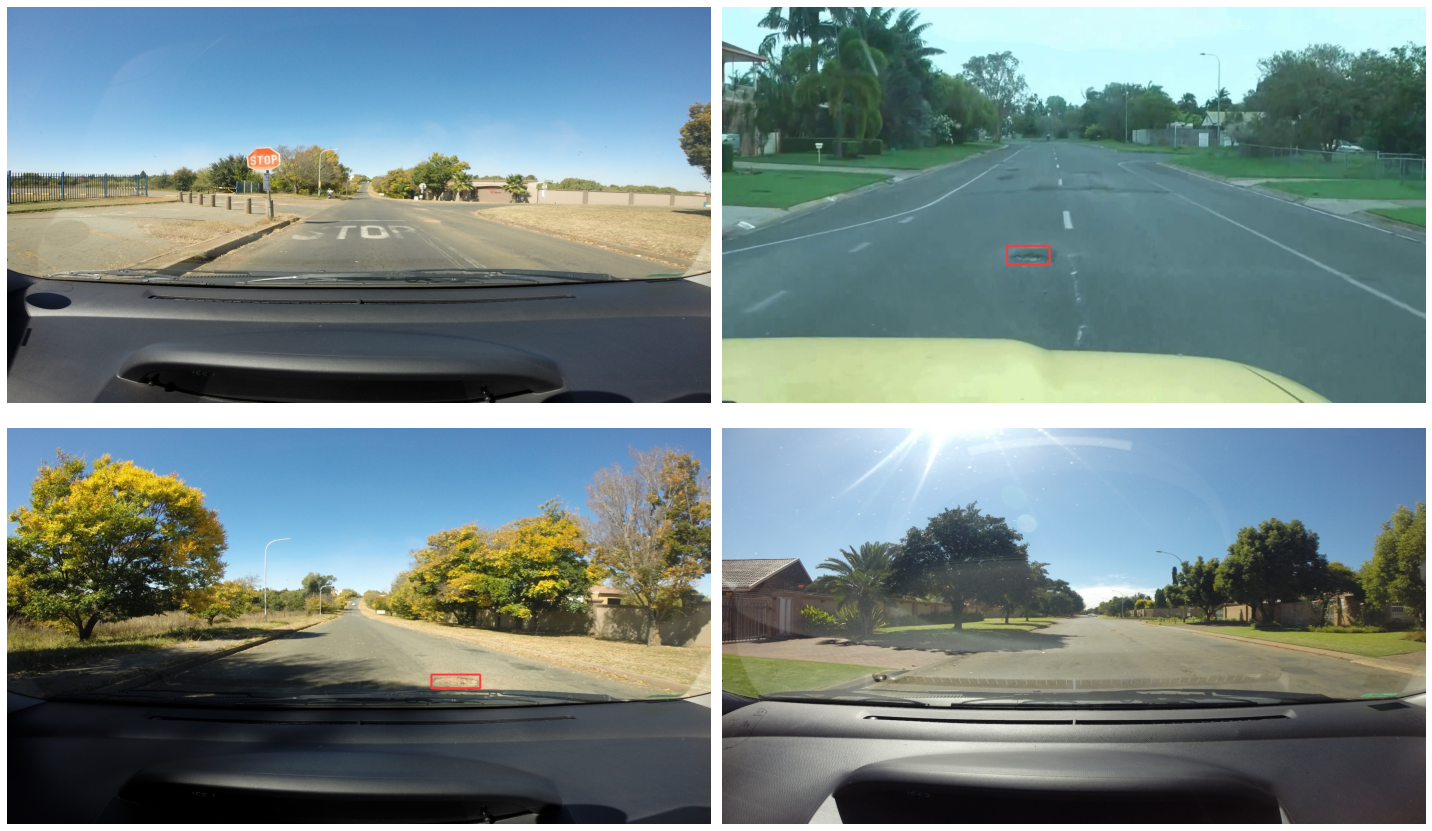

In [5]:
visualize('runs/detect/yolov8n_v8_50e_infer1280/')